This notebook contains the scripts to download the annotations of landmarks of Archey's frogs from Zooniverse and create the landmark DB

#Requirements

### Install required packages

We use the "panoptes_client" package to communicate with Zooniverse. If you don't have it installed, run the command below.

In [ ]:
!pip install panoptes_client

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for redo: filename=redo-2.0.4-cp37-none-any.whl size=11931 sha256=47d4c08c2607568cf58253e38d3521923b22f95105eb7b9e6ad571b5d8350416
  Stored in directory: /root/.cache/pip/wheels/7e/ca/39/576f2d470fab4725bb098ca3a1889ee540875e2bd072dc7ec0
Successfully built redo
  Created wheel for panoptes-client: filename=panoptes_client-1.3.0-cp37-none-any.whl size=30663 sha256=b51d17fc567d124a6760c817705bdf0be1cb0eda368f19cdb9e85fb862f890e9
  Stored in directory: /root/.cache/pip/wheels/fa/47/7f/52807dc212183f9e45497a2071717d85bef5658b9481fc4074
Successfully built panoptes-client


### Load required libraries

Load generic libraries

In [ ]:
import io
import zipfile
import json
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
from datetime import date
from panoptes_client import (
    SubjectSet,
    Subject,
    Project,
    Panoptes,
) 

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Connect to Zooniverse

You need to specify your Zooniverse username and password. Uploading and downloading information from Zooniverse is only accessible to those user with access to the project.

In [ ]:
# Your user name and password for Zooniverse. 
zoo_user = getpass.getpass('Enter your Zooniverse user')
zoo_pass = getpass.getpass('Enter your Zooniverse password')


# Connect to Zooniverse with your username and password
auth = Panoptes.connect(username=zoo_user, password=zoo_pass)

if not auth.logged_in:
    raise AuthenticationError("Your credentials are invalid. Please try again.")

# Connect to the Zooniverse project (our frog project # is 13355)
project = Project(13355)

#Download Zooniverse annotations

In [ ]:
WHAREORINA_DIR_FORMAT = "/content/gdrive/MyDrive/wildlife/Archeys_frogs/whareorino_{grid_letter_lower}"
PUKEOKAHU_DIR = "/content/gdrive/MyDrive/wildlife/Archeys_frogs/pukeokahu/Pukeokahu Frog Monitoring"
GRID_DIR_FORMAT = os.path.join(WHAREORINA_DIR_FORMAT, "Grid {grid_letter}")
INDIVIDUAL_FROGS_DIR_NAME = "Individual Frogs"
NEW_FROGS_DIR_NAME = "New Frogs"
GRID_LETTER_REGEX = re.compile("Grid (.)")
PUKEOKAHU_IDENTIFIER = "Pukeokahu"
# Determines the maximum amount of pixel difference between min and max of x,y
# As a percentage of image size, differences bigger than 
# MAX_PIXEL_PERCENT_DIFF will be discarded
MAX_PIXEL_PERCENT_DIFF = 0.03


In [ ]:
def get_file_path(subject_data_dict):
  # Searches for grid letter, using match because currently only at the beginning
  grid_letter = GRID_LETTER_REGEX.match(subject_data_dict['grid'])
  if grid_letter != None:
    grid_letter = grid_letter.group(1)
    # Find file in individual frogs dir
    grid_dir = GRID_DIR_FORMAT.format(grid_letter_lower = grid_letter.lower(), grid_letter = grid_letter)
  elif PUKEOKAHU_IDENTIFIER in subject_data_dict['grid']:
    grid_dir = PUKEOKAHU_DIR
  else:
    return None

  file_path = os.path.join(grid_dir, INDIVIDUAL_FROGS_DIR_NAME, subject_data_dict['frog_id'], subject_data_dict['filename'])
  if os.path.isfile(file_path):
    return file_path
  # Find file in new frog dir
  file_path = os.path.join(grid_dir, NEW_FROGS_DIR_NAME, subject_data_dict['filename'])
  if os.path.isfile(file_path):
    return file_path
  
  return None

In [ ]:
# Get the export classifications
export = project.get_export("classifications")

# Save the response as pandas data frame
classifications = pd.read_csv(
    io.StringIO(export.content.decode("utf-8")),
    usecols=[
             "user_name",
             "subject_ids",
             "subject_data",
             "classification_id",
             #"workflow_id",
             #"workflow_version",
             "annotations"
             ],
             )
# Convert JSON strings into Python dictionaries, providing access to key-value pairs.
classifications['annotations'] = [json.loads(q) for q in classifications.annotations]
classifications['subject_data'] = [json.loads(q) for q in classifications.subject_data]
classifications['image_path'] = [get_file_path(next(iter(q.values()))) for q in classifications.subject_data]


# Flatten annotations
x =[]
y = []
label = []
classification_id = []

for i,row in classifications.iterrows():
  class_id = row['classification_id']
  
  for t in row['annotations']:
    # Select survey Task = T0
    if t['task'] == 'T0':
      if len(t['value']) > 0:
        for l in t['value']:
          x.append(l['x'])
          y.append(l['y'])
          label.append(l['tool_label'])
          classification_id.append(class_id)
      else:
        x.append('')
        y.append('')
        label.append('')
        classification_id.append(class_id)
    
# Combine all the annotations into a data frame
annotations = pd.concat([
                     pd.DataFrame(x, columns =['x']),
                     pd.DataFrame(y, columns =['y']),
                     pd.DataFrame(label, columns =['label']),
                     pd.DataFrame(classification_id, columns =['classification_id'])],
                    axis=1)

# Drop metadata and index columns from original df
classifications = classifications.drop(columns=["annotations"])

# Add metadata information based on the classification id
flat_anotations = pd.merge(annotations, classifications, 
                           how="left", on=["classification_id"])


# Analyze Landmark distribution

In [ ]:
flat_anotations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10944 entries, 0 to 10943
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  10944 non-null  float64
 1   y                  10944 non-null  float64
 2   label              10944 non-null  object 
 3   classification_id  10944 non-null  int64  
 4   user_name          10944 non-null  object 
 5   subject_data       10944 non-null  object 
 6   subject_ids        10944 non-null  int64  
 7   image_path         10944 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 769.5+ KB


In [ ]:
flat_anotations.head()

,x,y,label,classification_id,user_name,subject_data,subject_ids,image_path
0,629.945068,877.188782,Tip of snout,278017541,victorav,"{'50445441': {'retired': None, 'grid': 'Grid A...",50445441,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
1,1227.169678,910.180786,Vent,278017541,victorav,"{'50445441': {'retired': None, 'grid': 'Grid A...",50445441,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
2,733.764771,775.934021,Right eye,278017541,victorav,"{'50445441': {'retired': None, 'grid': 'Grid A...",50445441,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
3,738.509338,991.895691,Left eye,278017541,victorav,"{'50445441': {'retired': None, 'grid': 'Grid A...",50445441,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
4,912.628296,750.835022,Right front leg,278017541,victorav,"{'50445441': {'retired': None, 'grid': 'Grid A...",50445441,/content/gdrive/MyDrive/wildlife/Archeys_frogs...


Building the annotation DB

In [ ]:
df = flat_anotations.copy()
df.dropna()
df = df.drop(['user_name', 'subject_data', 'subject_ids'], axis = 1)

In [ ]:
pivot_columns = ['x','y']
df = df.pivot_table(pivot_columns, index = 'classification_id', columns = 'label')
df.columns = ['_'.join([col[0],str(col[1]).replace(' ', '_')]).strip() for col in df.columns.values]

In [ ]:
df = pd.merge(df, flat_anotations[['classification_id','image_path']], left_on = 'classification_id', right_on = 'classification_id', how = 'left')

In [ ]:
df = df.groupby(['classification_id']).first()

In [ ]:
df.head()

,x_Left_eye,x_Left_front_leg,x_Right_eye,x_Right_front_leg,x_Tip_of_snout,x_Vent,y_Left_eye,y_Left_front_leg,y_Right_eye,y_Right_front_leg,y_Tip_of_snout,y_Vent,image_path
classification_id,,,,,,,,,,,,,
278017541,738.509338,894.585632,733.764771,912.628296,629.945068,1227.169678,991.895691,993.976257,775.934021,750.835022,877.188782,910.180786,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
278017631,862.525940,1065.978394,824.746643,1014.474121,741.838806,1328.153687,1207.369629,1189.156738,1003.786621,946.049133,1128.011841,1027.318481,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
278017792,721.188538,749.142212,941.945251,974.177246,812.440430,904.533569,912.927307,1035.690063,890.874451,1005.549194,759.675110,1389.845337,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
278017887,685.321655,796.249817,687.541260,794.623474,579.231567,1072.399170,953.123169,973.488159,786.613281,753.871826,867.909485,868.615234,/content/gdrive/MyDrive/wildlife/Archeys_frogs...
278018003,1287.566772,1381.586914,1301.994873,1426.487305,1198.638184,1645.269043,1135.975098,1161.637939,977.086121,974.854553,1040.339111,1105.348999,/content/gdrive/MyDrive/wildlife/Archeys_frogs...


Generating a few statistics

How many images were classified 1,2,3,.... times

In [ ]:
df.value_counts('image_path').value_counts()

1    1478
2     170
3       2
dtype: int64

Percentage of images that are classified 1,2,3,... times

In [ ]:
df.value_counts('image_path').value_counts(normalize = True)

1    0.895758
2    0.103030
3    0.001212
dtype: float64

Creating an new df easier to work with to find distances between classification points

In [ ]:
df_v = flat_anotations.copy()
df_v.dropna()
df_v = df_v.drop(['user_name', 'subject_data', 'subject_ids'], axis = 1)

In [ ]:
df_v = df_v.groupby(['image_path', 'label']).agg(x = ('x', 'mean'), 
                                               y = ('y', 'mean'), 
                                               x_range=('x', lambda x: x.max() - x.min()),
                                               y_range=('y', lambda y: y.max() - y.min())
                                               )
df_v['point_max_diff'] = df_v.apply(lambda row: np.linalg.norm((row.x_range,row.y_range)), axis=1)


Max point diff:

In [ ]:
df_v[df_v['point_max_diff'] == np.max(df_v['point_max_diff'])]

,,x,y,x_range,y_range,point_max_diff
image_path,label,,,,,
/content/gdrive/MyDrive/wildlife/Archeys_frogs/whareorino_d/Grid D/Individual Frogs/342/1_00-6960.jpg,Tip of snout,284.982968,407.878212,514.810675,917.688889,1052.227602


Looking at the distribution of the distances between duplicate annotations

In [ ]:
image_sizes = []
diff_ratios = []
for im_path in df_v.index.get_level_values('image_path').unique():
  im = cv2.imread(im_path)
  im_size = im.shape[:2]
  image_sizes.append(im_size)
  im_diff_width = np.max(df_v.loc[[im_path]]['x_range'])
  im_diff_height = np.max(df_v.loc[[im_path]]['y_range'])
  im_diff_p = np.divide((im_diff_height, im_diff_width), im_size)
  diff_ratios.append([np.linalg.norm(im_diff_p), im_path])

image_sizes = np.array(image_sizes)
diff_ratios = np.array(diff_ratios)

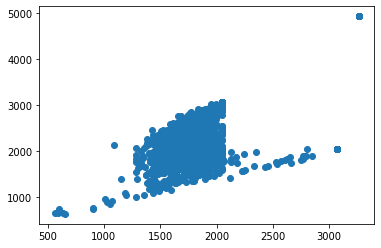

In [ ]:
plt.scatter(*zip(*image_sizes))
plt.show()

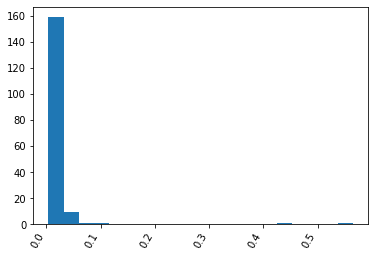

In [ ]:
diffs = np.float32(diff_ratios[:,0])
fig, ax = plt.subplots()
ax.hist(diffs[np.where(diffs != 0)], bins = 20)
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.show()

In [ ]:
np.max(diffs)

0.56504095

In [ ]:
np.mean(diffs[diffs != 0])

0.021413565

Highest point difference is currently 4 percent of the image
therefore it isn't a substancial difference and whole classifications are kept.
MAX_PIXEL_DIFF = 0.05 (defined before hand with all the constants)

In [ ]:
non_valid_images = diff_ratios[np.where(np.float32(diff_ratios[:,0]) > MAX_PIXEL_PERCENT_DIFF)][:, 1]

In [ ]:
df = df[~np.isin(df['image_path'], non_valid_images)]

In [ ]:
df = df.groupby(['image_path']).mean()

In [ ]:
df.reset_index(inplace = True)

In [ ]:
cols = ['image_path', 'x_Left_eye', 'y_Left_eye', 'x_Left_front_leg', 'y_Left_front_leg', 
        'x_Right_eye', 'y_Right_eye', 'x_Right_front_leg', 'y_Right_front_leg', 
        'x_Tip_of_snout', 'y_Tip_of_snout', 'x_Vent', 'y_Vent']
df = df[cols]

In [ ]:
# Using loop and not apply because this is considerably faster
image_sizes = []
for im_path in df.image_path:
  im = cv2.imread(im_path)
  im_size = im.shape[:2]
  image_sizes.append(im_size)

image_sizes = np.array(image_sizes)

In [ ]:
df['original_width_size'] = image_sizes[:, 1]
df['original_height_size'] = image_sizes[:, 0]

In [ ]:
df.to_pickle("./gdrive/MyDrive/wildlife/Archeys_frogs/image_path_anotations_db.pkl")

In [ ]:
# Quick validation that nothing weird happend
r_l = []
for i in df.index:
  row = df.loc[i]
  im = cv2.imread(row.image_path)
  r_l.append(not (im.shape[1] == row.original_width_size and im.shape[0] == row.original_height_size))

r_l = np.array(r_l)

In [ ]:
np.sum(r_l)

0

In [ ]:
len(df)

1633